### Classification based on point cloud features

In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1

In [3]:
def get_scores(X_train, X_valid, y_train, param, num_round):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
    score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
    score = np.around(score, 3)
    
    return score

In [4]:
from sklearn import metrics
def buildROC(target_test,test_preds, num_round,structure):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    #plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label=str(num_round))#, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    loc = np.random.choice(range(len(fpr)),1)[0]
    plt.text(fpr[loc],tpr[loc],structure)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc

In [5]:
paired_structures = ['5N', '6N', '7nn','7N', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [95]:
auc_s=[0.95,0.95,0.98,0.95,0.97,0.94,0.89,0.96,0.96,0.92,0.94,0.92,0.895,0.97,0.97,0.95,0.86,0.915,0.93,0.97,0.95,0.92,\
      0.95,0.98,0.965,0.86,0.82,0.88]

In [80]:
len(auc_s)

28

In [6]:
stack = 'MD594'
feature_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features/'+stack+'/'
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features/MD589/'


In [61]:
!mkdir figures
fn = 'figures/'

mkdir: figures: File exists


5N 480 479 0.7778936392075079
6N 269 216 0.6556701030927835
7nn 999 1000 0.9119559779889945
7N 829 826 0.7969788519637462
Amb 120 120 0.85
LC 239 240 0.7974947807933194
LRt 720 720 0.7791666666666667
Pn 940 921 0.7678667383127351
Tz 439 437 0.8287671232876712
VLL 650 650 0.7607692307692308
RMC 500 500 0.822
SNC 940 883 0.7526055951727921
SNR 999 1000 0.7058529264632316
3N 230 230 0.8260869565217391
4N 140 113 0.849802371541502
Sp5I 707 709 0.8022598870056498
Sp5O 680 680 0.6955882352941176
Sp5C 1000 1000 0.736
PBG 250 233 0.8198757763975155
10N 330 271 0.826955074875208
VCA 659 638 0.8550501156515035
VCP 449 416 0.7514450867052023
DC 850 811 0.7718242022877785
AP 190 190 0.8947368421052632
12N 389 390 0.8189987163029525
RtTg 800 800 0.6825
SC 999 1000 0.6658329164582291
IC 999 1000 0.7208604302151076


Text(0.5, 1.0, 'MD594')

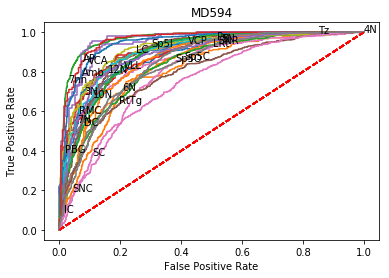

In [7]:
acc_all=[]
num_round=np.array([100])
auc_all = np.zeros((len(num_round), len(all_structures)))
#plt.figure(figsize=[15,50])
plt.figure()
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    #plt.figure()
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    fp =[]
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_positive.pkl') 
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_negative.pkl')
    X_valid = []
    y_valid = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_valid.extend(np.array(clouds))
        y_valid.extend([1-state]*len(clouds))
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i],structure)
        auc_all[i,seq] = auc
    #plt.title(structure+' AUC = %0.2f'%auc)
    acc_all.append(acc)
    print(structure, len(y_valid)-sum(y_valid), sum(y_valid), acc)
    #plt.savefig(fn+stack+'_'+structure+'_ROC.jpg')
plt.title(stack)
#plt.savefig(fn+stack+'_200_ROC.jpg')

In [19]:
good_features = []
for i in np.where(auc_all>auc_all.mean())[1]:
    good_features.append(all_structures[i])
bad_features = []
for i in np.where(auc_all<=auc_all.mean())[1]:
    bad_features.append(all_structures[i])

In [20]:
len(good_features),len(bad_features)

(17, 11)

In [34]:
fp = os.environ['ROOT_DIR'] + 'CSHL_results/'
#os.mkdir(fp)
good_fp = fp + 'good/'
#os.mkdir(good_fp)
for struc in good_features:
    #os.mkdir(good_fp + struc + '/')
    source = os.environ['ROOT_DIR'] + 'CSHL_hsv/MD594/'+struc +'/*'
    destination = good_fp + struc + '/test'
    os.mkdir(destination)
    ! mv -v $source $destination

bad_fp = fp + 'bad/'
#os.mkdir(bad_fp)
for struc in bad_features:
    #os.mkdir(bad_fp + struc + '/')
    source = os.environ['ROOT_DIR'] + 'CSHL_hsv/MD594/'+struc +'/*'
    destination = bad_fp + struc + '/test'
    os.mkdir(destination)
    ! mv -v $source $destination

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/5N/5N_148.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/5N/test/5N_148.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/5N/5N_149.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/5N/test/5N_149.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/5N/5N_150.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/5N/test/5N_150.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/5N/5N_151.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/5N/test/5N_151.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/5N/5N_152.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/5N/test/5N_152.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/5N/5N_153.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/5N/test/5N_153.tif
/Users/kuiqian/BstemAt

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/7N/7N_151.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_151.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/7N/7N_152.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_152.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/7N/7N_153.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_153.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/7N/7N_154.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_154.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/7N/7N_155.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_155.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/7N/7N_156.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/7N/test/7N_156.tif
/Users/kuiqian/BstemAt

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Amb/Amb_167.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_167.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Amb/Amb_168.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_168.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Amb/Amb_169.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_169.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Amb/Amb_170.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_170.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Amb/Amb_171.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_171.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Amb/Amb_172.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Amb/test/Amb_172.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Tz/Tz_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_190.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Tz/Tz_191.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_191.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Tz/Tz_192.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_192.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Tz/Tz_194.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_194.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Tz/Tz_195.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_195.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Tz/Tz_196.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/Tz/test/Tz_196.tif
/Users/kuiqian/BstemAt

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RMC/RMC_184.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_184.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RMC/RMC_185.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_185.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RMC/RMC_186.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_186.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RMC/RMC_188.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_188.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RMC/RMC_189.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_189.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RMC/RMC_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/RMC/test/RMC_190.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/3N/3N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_211.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/3N/3N_212.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_212.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/3N/3N_213.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_213.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/3N/3N_214.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_214.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/3N/3N_215.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_215.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/3N/3N_216.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/3N/test/3N_216.tif
/Users/kuiqian/BstemAt

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/10N/10N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_211.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/10N/10N_212.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_212.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/10N/10N_213.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_213.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/10N/10N_214.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_214.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/10N/10N_215.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_215.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/10N/10N_216.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/10N/test/10N_216.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/VCP/VCP_105.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCP/test/VCP_105.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/VCP/VCP_106.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCP/test/VCP_106.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/VCP/VCP_107.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCP/test/VCP_107.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/VCP/VCP_108.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCP/test/VCP_108.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/VCP/VCP_109.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCP/test/VCP_109.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/VCP/VCP_110.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/VCP/test/VCP_110.ti

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/AP/AP_221.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_221.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/AP/AP_222.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_222.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/AP/AP_223.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_223.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/AP/AP_224.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_224.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/AP/AP_225.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_225.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/AP/AP_226.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/good/AP/test/AP_226.tif
/Users/kuiqian/BstemAt

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/6N/6N_207.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test/6N_207.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/6N/6N_208.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test/6N_208.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/6N/6N_209.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test/6N_209.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/6N/6N_210.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test/6N_210.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/6N/6N_211.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test/6N_211.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/6N/6N_212.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test/6N_212.tif
/Users/kuiqian/BstemAtlasDat

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNC/SNC_141.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_141.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNC/SNC_142.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_142.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNC/SNC_143.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_143.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNC/SNC_144.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_144.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNC/SNC_145.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_145.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNC/SNC_146.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNC/test/SNC_146.tif
/Use

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNR/SNR_125.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_125.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNR/SNR_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNR/SNR_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNR/SNR_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNR/SNR_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SNR/SNR_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SNR/test/SNR_130.tif
/Use

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5I/Sp5I_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5I/test/Sp5I_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5I/Sp5I_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5I/test/Sp5I_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5I/Sp5I_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5I/test/Sp5I_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5I/Sp5I_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5I/test/Sp5I_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5I/Sp5I_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5I/test/Sp5I_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5I/Sp5I_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5O/Sp5O_126.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_126.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5O/Sp5O_127.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_127.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5O/Sp5O_128.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_128.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5O/Sp5O_129.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_129.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5O/Sp5O_130.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5O/test/Sp5O_130.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5O/Sp5O_132.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5C/Sp5C_134.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_134.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5C/Sp5C_135.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_135.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5C/Sp5C_136.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_136.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5C/Sp5C_137.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_137.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5C/Sp5C_138.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5C/test/Sp5C_138.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/Sp5C/Sp5C_139.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/Sp5

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RtTg/RtTg_188.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_188.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RtTg/RtTg_189.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_189.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RtTg/RtTg_190.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_190.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RtTg/RtTg_191.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_191.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RtTg/RtTg_192.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtTg/test/RtTg_192.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/RtTg/RtTg_194.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/RtT

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SC/SC_137.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/test/SC_137.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SC/SC_138.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/test/SC_138.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SC/SC_139.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/test/SC_139.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SC/SC_140.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/test/SC_140.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SC/SC_141.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/test/SC_141.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/SC/SC_142.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/SC/test/SC_142.tif
/Users/kuiqian/BstemAtlasDat

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/IC/IC_138.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_138.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/IC/IC_139.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_139.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/IC/IC_140.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_140.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/IC/IC_141.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_141.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/IC/IC_142.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_142.tif
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_hsv/MD594/IC/IC_143.tif -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/IC/test/IC_143.tif
/Users/kuiqian/BstemAtlasDat

5N 440 440 0.8295454545454546
6N 43 50 0.8928571428571429
7nn 1000 1000 0.9233333333333333
7N 890 884 0.8442776735459663
Amb 130 130 0.8846153846153846
LC 240 240 0.875
LRt 760 760 0.8070175438596491
Pn 992 1000 0.8979933110367893
Tz 500 500 0.87
VLL 690 690 0.8502415458937198
RMC 570 570 0.8421052631578947
SNC 785 829 0.8556701030927835
SNR 1000 1000 0.8033333333333333
3N 240 240 0.8958333333333334
4N 120 45 0.9
Sp5I 730 729 0.8378995433789954
Sp5O 662 680 0.7593052109181141
Sp5C 999 1000 0.77
PBG 216 260 0.8881118881118881
10N 460 405 0.8923076923076924
VCA 659 647 0.8698979591836735
VCP 490 475 0.8344827586206897
DC 1000 997 0.8683333333333333
AP 145 149 0.9662921348314607
12N 390 388 0.8717948717948718
RtTg 150 150 0.7555555555555555
SC 998 1000 0.7283333333333334
IC 1000 1000 0.82


Text(0.5, 1.0, 'MD589')

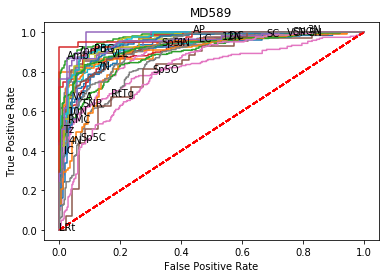

In [8]:
acc_all_train=[]
num_round=np.array([100])
auc_all_train = np.zeros((len(num_round), len(all_structures)))
plt.figure() #figsize=[15,50]
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([1-state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i],structure)
        auc_all_train[i,seq] = auc
    #plt.title(structure+' AUC = %0.2f'%auc)
    acc_all_train.append(acc)
    print(structure, len(labels)-sum(labels), sum(labels), acc)
plt.title('MD589')
#plt.savefig(fn+'MD589_200_ROC.jpg')

In [96]:
auc_s=np.array(auc_s)

In [97]:
auc_both=np.concatenate((auc_all,auc_s.reshape(1,-1)),axis=0)
auc_both,auc_both.shape[0]

(array([[0.90901835, 0.87993081, 0.9523975 , 0.89754514, 0.95229167,
         0.87580729, 0.85113873, 0.91032506, 0.92332796, 0.89632308,
         0.91724   , 0.85559264, 0.850872  , 0.93171078, 0.97262958,
         0.87804784, 0.80178093, 0.80918118, 0.89066094, 0.89636587,
         0.93143939, 0.90323985, 0.89016755, 0.95012465, 0.94153517,
         0.80719844, 0.7435705 , 0.8663785 ],
        [0.95      , 0.95      , 0.98      , 0.95      , 0.97      ,
         0.94      , 0.89      , 0.96      , 0.96      , 0.92      ,
         0.94      , 0.92      , 0.895     , 0.97      , 0.97      ,
         0.95      , 0.86      , 0.915     , 0.93      , 0.97      ,
         0.95      , 0.92      , 0.95      , 0.98      , 0.965     ,
         0.86      , 0.82      , 0.88      ]]), 2)

In [11]:
auc_both=np.concatenate((np.array(auc_all).reshape(1,-1),np.array(auc_all_train).reshape(1,-1)),axis=0)
auc_both,auc_both.shape[0]

(array([[0.87656794, 0.82597584, 0.96674775, 0.88284698, 0.94243056,
         0.9103818 , 0.85337867, 0.8870602 , 0.91434141, 0.88152189,
         0.899888  , 0.82187658, 0.82902402, 0.91663516, 0.96302149,
         0.89412145, 0.7880958 , 0.8294805 , 0.90804292, 0.90427709,
         0.94749692, 0.86155131, 0.88591427, 0.96236842, 0.88703777,
         0.79374687, 0.74744695, 0.84005005],
        [0.92278292, 0.94871795, 0.97651552, 0.9108722 , 0.96842105,
         0.92666409, 0.89529507, 0.96139344, 0.95479422, 0.92535498,
         0.90261762, 0.92298534, 0.88511091, 0.96613777, 0.96691176,
         0.92739371, 0.82374544, 0.85778851, 0.95101959, 0.96278019,
         0.94115656, 0.88741438, 0.93134493, 0.97764228, 0.94953893,
         0.82335477, 0.8137113 , 0.9171195 ]]), 2)

Text(0.5, 1.0, '  AUC = [0.879 0.921]')

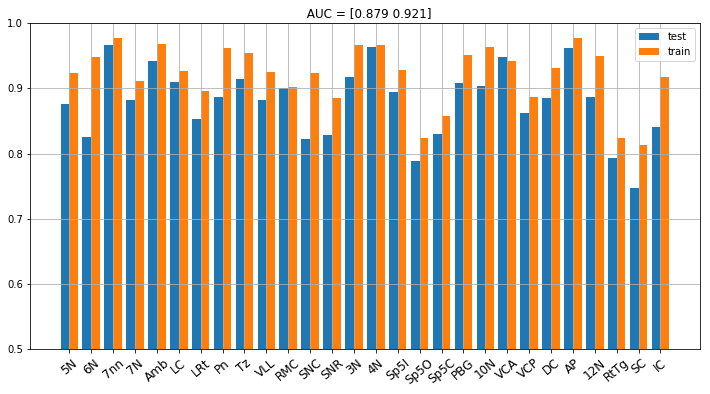

In [12]:
figure(figsize=(12,6))
index = np.arange(auc_both.shape[1])
width = 0.4
labels=['test','train'] #['Present','Yuncong']  
for i in range(auc_both.shape[0]):
    plt.bar(index+i*width, auc_both[i,:], width, label=labels[i])
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title('  AUC = '+str(np.round(np.mean(auc_both,1),3)))
#plt.savefig(fn+'comp.jpg')

# figure(figsize=(12,6))
# index = np.arange(acc_both.shape[1])
# width = 0.4
# labels=['Present','Yuncong']
# for i in range(auc_both.shape[0]):
#     plt.bar(index+i*width, acc_both[i,:], width, label=labels[i])
# plt.xticks(rotation=40)
# plt.xticks(fontsize=12)
# plt.xticks(index+width/2, all_structures)
# plt.grid(True)
# plt.ylim(0.5,1)
# plt.legend()
# plt.title('  ACC = '+str(np.round(np.mean(acc_both,1),3)))
# #plt.savefig(fn+'ACC_200.jpg')

In [39]:
bad_features

['6N', 'LC', 'LRt', 'SNC', 'SNR', 'Sp5I', 'Sp5O', 'Sp5C', 'RtTg', 'SC', 'IC']

In [40]:
train_good_but_test_bad = ['6N','LC','LRt','SNC','RtTg','IC']

In [42]:
fp = os.environ['ROOT_DIR'] + 'CSHL_results/'
#os.mkdir(fp)
tfp = fp + 'train_good_but_test_bad/'
os.mkdir(tfp)
for struc in train_good_but_test_bad:
    #os.mkdir(tfp + struc + '/')
    source = fp+'bad/'+struc +'/*'
    destination = tfp + struc + '/'
    os.mkdir(destination)
    ! mv -v $source $destination

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/test -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/6N/test
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/6N/train -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/6N/train
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LC/test -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/LC/test
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LC/train -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/LC/train
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/test -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_bad/LRt/test
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/bad/LRt/train -> /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_results/train_good_but_test_ba

In [60]:
fp = os.environ['ROOT_DIR'] + 'CSHL_results/'
for structure in paired_structures:
    if structure in good_features:
        fn = fp+'good/'+ structure +'/'
    elif structure in train_good_but_test_bad:
        fn = fp+'train_good_but_test_bad/'+ structure +'/'
    else:
        fn = fp+'bad/'+ structure +'/'
    if structure == '7nn':
        structure = '7n'
    for state in ['train','test']:
        files = [dir for dir in glob(fn+state+'/*')]
        if os.path.exists(fn+state+'/one_side'):
            continue
        else:
            os.mkdir(fn+state+'/one_side')
            os.mkdir(fn+state+'/the_other')
        sections = []
        for name in files:
            slash=name.rfind('_')
            dot = name.rfind('.')
            sections.append(int(name[slash+1:dot]))
        sections = np.sort(sections)
        mark = np.argmax(sections[1:]-sections[:-1])
        for section in sections[:mark+1]:
            filename = fn + state + '/'+structure +'_'+str(section)+'.tif'
            destination = fn+state+'/one_side/'
            ! mv $filename $destination
        for section in sections[mark+1:]:
            filename = fn + state + '/'+structure +'_'+str(section)+'.tif'
            destination = fn+state+'/the_other/'
            ! mv $filename $destination

In [53]:
structure = '6N'
if structure in good_features:
    fn = fp+'good/'+ structure +'/'
elif structure in train_good_but_test_bad:
    fn = fp+'train_good_but_test_bad/'+ structure +'/'
else:
    fn = fp+'bad/'+ structure +'/'
for state in ['train','test']:
    files = [dir for dir in glob(fn+state+'/*')]
    sections = []
    for name in files:
        slash=name.rfind('_')
        dot = name.rfind('.')
        sections.append(int(name[slash+1:dot]))
    sections = np.sort(sections)
    np.argmax(sections[1:]-sections[:-1])


2
13


In [34]:
acc_both=np.concatenate((np.array(acc_all).reshape(1,-1),np.array(acc_all_train).reshape(1,-1)),axis=0)
acc_both,acc_both.shape[0]

(array([[0.79979145, 0.77113402, 0.8885    , 0.82246377, 0.8625    ,
         0.77291667, 0.77206393, 0.79074771, 0.86887115, 0.78692308,
         0.845     , 0.76522216, 0.711     , 0.85      , 0.90909091,
         0.78083157, 0.70955882, 0.67783892, 0.76397516, 0.80033278,
         0.83898305, 0.81177829, 0.79289585, 0.87105263, 0.86666667,
         0.720625  , 0.643     , 0.7695    ],
        [0.8219697 , 0.89285714, 0.92      , 0.87617261, 0.91025641,
         0.91666667, 0.85526316, 0.8729097 , 0.86333333, 0.84541063,
         0.87426901, 0.85360825, 0.78666667, 0.90972222, 0.94      ,
         0.83333333, 0.75682382, 0.75833333, 0.88811189, 0.90384615,
         0.90585242, 0.88275862, 0.88647746, 0.92134831, 0.85897436,
         0.86666667, 0.7       , 0.85      ]]), 2)

Text(0.5, 1.0, '  AcC = [0.795 0.863]')

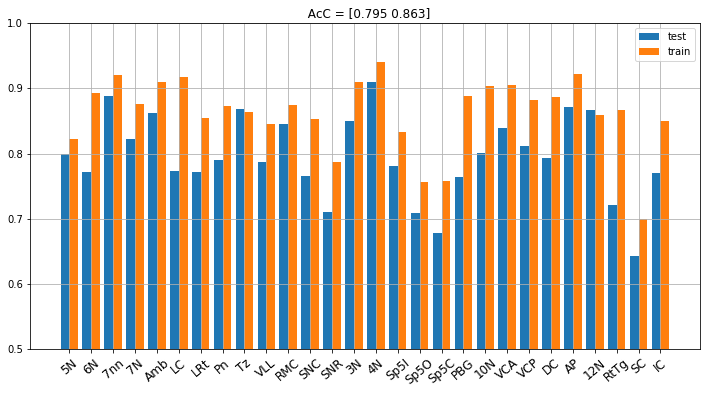

In [35]:
figure(figsize=(12,6))
index = np.arange(acc_both.shape[1])
width = 0.4
labels=['test','train']
for i in range(auc_both.shape[0]):
    plt.bar(index+i*width, acc_both[i,:], width, label=labels[i])
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title('  AcC = '+str(np.round(np.mean(acc_both,1),3)))
#plt.savefig(fn+stack+'_AUC.jpg')

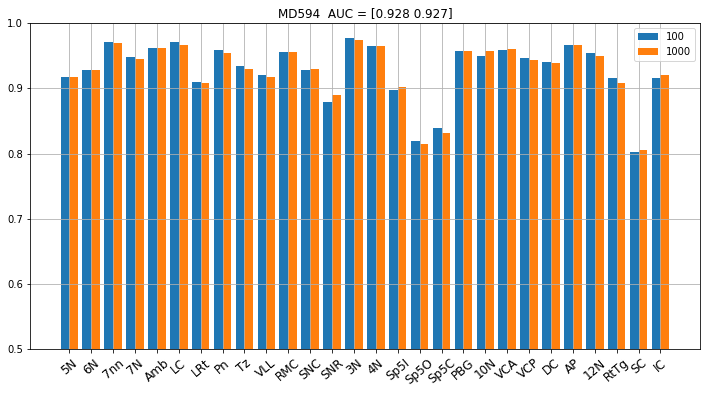

In [17]:
figure(figsize=(12,6))
index = np.arange(auc_all.shape[1])
width = 0.4
for i in range(len(num_round)):
    plt.bar(index+i*width, auc_all[i,:], width, label=str(num_round[i]))
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(stack+'  AUC = '+str(np.round(np.mean(auc_all,1),3)))
plt.savefig(fn+'MD589_AUC.jpg')

In [30]:
!aws s3 ls s3://mousebrainatlas-data/CSHL_data_processed/MD585/

                           PRE MD585_custom_transforms/
                           PRE MD585_elastix_output/
                           PRE MD585_masks/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/
                           PRE MD585_prep1_thumbnail/
                           PRE MD585_prep1_thumbnail_mask/
                           PRE MD585_prep2_down8_grayJpeg/
                           PRE MD585_prep2_lossless/
                           PRE MD585_prep2_lossless_gray/
                           PRE MD585_prep2_lossless_jpeg/
                           PRE MD585_prep2_thumbnail/
                           PRE MD585_prep3_lossless/
                           PRE MD585_prep3_lossless_jpeg/
                           PRE MD585_prep3_thumbnail/
                           PRE MD585_prep5_thumbnail/
                           PRE 

In [7]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
for i in range(10):
    name = origin[i]
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
columns.append(origin[-1])

In [8]:
sets = columns
! mkdir FeatureMap

mkdir: FeatureMap: File exists


LC 479 0.875


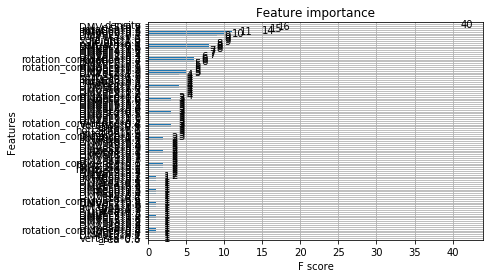

In [13]:
structure = 'LC'
fp =[dir for dir in glob(cell_dir+structure+'/*')]
features = []
labels = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    features.extend(np.array(clouds))
    labels.extend([state]*len(clouds))
features = np.array(features)
labels = np.array(labels)
data = pd.DataFrame(features,columns=sets)
label = pd.DataFrame(labels)
X_train, X_valid, y_train, y_valid = train_test_split(data, label, test_size=0.30, random_state=6)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_valid)
num_round = 100
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
y_pred_valid = np.around(score, 3)
pred = y_pred_valid>0
acc = sum(pred.reshape(-1,1) == np.array(y_valid))/len(y_valid)
print(structure, features.shape[0], acc)
xgb.plot_importance(bst)
# plt.savefig('FeatureMap/'+structure+'.jpg')
# fig = plt.figure(figsize=(18,18))
# iax = fig.add_subplot(111)
# xgb.plot_tree(bst,ax=iax)
# plt.savefig('FeatureMap/'+structure+'_tree.jpg')

In [9]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [13]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    plot(x,y)
    return x,y

In [29]:
setup_download_from_s3('CSHL_cells_features/MD589/Properties/7N/')

download: s3://mousebrainatlas-data/CSHL_cells_features/MD589/Properties/7N/MD589_7N_negative.pkl to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_cells_features/MD589/Properties/7N/MD589_7N_negative.pkl
download: s3://mousebrainatlas-data/CSHL_cells_features/MD589/Properties/7N/MD589_7N_positive.pkl to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_cells_features/MD589/Properties/7N/MD589_7N_positive.pkl


In [2]:
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_cells_features/MD589/Properties/'

In [3]:
fp = [dir for dir in glob(cell_dir+'10N/*')]
sample = pickle.load(open(fp[0],'rb'))

In [7]:
sample

,DMVec,area,height,horiz_std,left,mean,padded_size,rotation,rotation_confidence,std,top,vert_std,width
1,"[-3.5152447958216593, -2.4316020148778397, -0....",412,24,4.152117,460,10.763241,51,69.735691,1268.076206,20.917839,449,10.042974,34
2,"[4.67530863811092, -2.4246536527461915, -1.452...",66,15,1.868604,511,3.403200,51,10.968166,926.371727,10.802399,458,3.202521,9
3,"[3.998911116627495, -0.9465917069956651, -1.38...",109,14,2.532682,541,8.241966,51,31.166937,329.498842,17.332238,471,3.316311,15
4,"[3.0411400440305685, -0.13535307086633966, -0....",158,17,2.069978,521,4.198367,51,49.565150,8608.868286,12.370498,479,4.757877,21
5,"[-2.007957337357257, 2.4614147355173106, -0.98...",25,5,1.195420,567,3.595041,15,-49.199080,44.314805,8.034614,478,1.384819,6
6,"[0.4876208951898243, 0.3527127042971828, -0.45...",15,3,0.744536,581,1.049587,15,72.210510,313.772581,3.159274,481,1.450085,7
7,"[-948.6597593791562, 0.09282533612197208, 0.02...",369,26,3.128848,456,9.485198,201,57.911175,5830.029236,24.849796,484,8.592631,30
8,"[-851.5699899794856, -0.7078868175606065, -0.4...",751,39,8.338235,575,8.512356,201,-56.520100,952.147502,20.955519,488,10.584109,46
9,"[3.5226356651475585, -0.011158427050531973, -1...",144,15,2.556931,512,9.844800,51,28.968349,677.567077,20.178244,503,3.593947,14
10,"[-3.3644755350965387, -1.255952782345239, -2.3...",521,24,5.308857,536,13.498416,51,69.078687,4439.118978,26.462562,504,7.309501,33


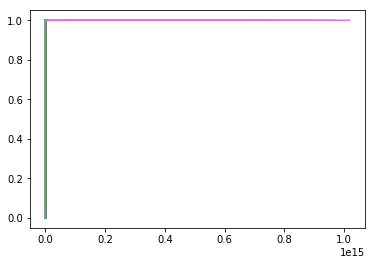

In [35]:
thresholds = {}
for structure in all_structures:
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    tens = []
    for state in range(2):
        cells = pickle.load(open(fp[state],'rb'))
        cells = cells.drop(['left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        features.extend(origin)
    features = np.array(features)
    for k in range(features.shape[1]):
        x, y = CDF(features[:,k])
        ten = [x[np.argmin(np.absolute(y-0.1*(j+1)))] for j in range(10)]
        tens.extend(ten)
    thresholds[structure]=tens

In [48]:
test = np.array(thresholds['7nn'])

In [54]:
len(thresholds)

28

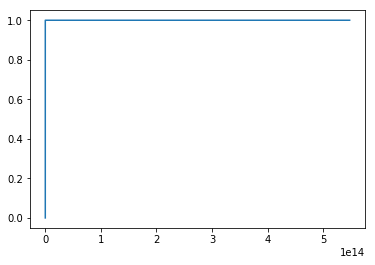

In [52]:
x,y = CDF(features[:,16])

In [53]:
import pickle

In [57]:
fp = os.environ['ROOT_DIR']+'/CSHL_data_processed/MD589/Thresholds.pkl'
pickle.dump(thresholds,open(fp,'wb'))

In [59]:
fp = os.environ['ROOT_DIR']+'CSHL_patch_samples_features/MD589/4N/MD589_4N_positive.pkl'
feature = pickle.load(open(fp,'rb'))

In [62]:
feature = np.array(feature)

In [64]:
feature[0,:]

array([ 0.07692308,  0.15384615,  0.20512821,  0.25641026,  0.35897436,
        0.56410256,  0.69230769,  0.79487179,  0.87179487,  0.97435897,
        0.15384615,  0.25641026,  0.35897436,  0.46153846,  0.61538462,
        0.76923077,  0.82051282,  0.94871795,  0.97435897,  0.97435897,
        0.07692308,  0.23076923,  0.35897436,  0.46153846,  0.48717949,
        0.61538462,  0.69230769,  0.76923077,  0.92307692,  0.97435897,
        0.07692308,  0.23076923,  0.30769231,  0.41025641,  0.46153846,
        0.58974359,  0.64102564,  0.69230769,  0.84615385,  0.97435897,
        0.1025641 ,  0.20512821,  0.30769231,  0.38461538,  0.46153846,
        0.53846154,  0.64102564,  0.69230769,  0.79487179,  0.97435897,
        0.05128205,  0.15384615,  0.20512821,  0.35897436,  0.43589744,
        0.51282051,  0.69230769,  0.74358974,  0.87179487,  0.97435897,
        0.12820513,  0.25641026,  0.43589744,  0.58974359,  0.64102564,
        0.71794872,  0.74358974,  0.76923077,  0.84615385,  0.97

In [31]:
def CDF_test(x, color):
    x=sort(x)
    size=x.shape[0]
    y=arange(0,size)/size
    threshold = (x.max()-x.min())/10
    ten_x = [x[np.argmin(np.absolute(x-x.min()-threshold*(j+1)))] for j in range(10)]
    ten_y = [y[np.argmin(np.absolute(x-x.min()-threshold*(j+1)))] for j in range(10)]
    if color:
        plot(x,y,color)
        plot(ten_x,ten_y,'ro')
    else:
        plot(x,y)
        plot(ten_x,ten_y,'o')
    return ten_x, ten_y

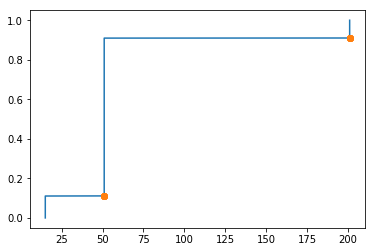

In [32]:
m,n = CDF_test(features[:,14], False)

In [14]:
for structure in all_structures:
    #structure = '12N'
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    y_pred_valid = get_scores(X_train, X_valid, y_train, param)
    pred = y_pred_valid>0
    #pred = get_predictions(y_pred_valid)
    acc = sum(pred ==y_valid)/len(y_valid)
    print(structure, features.shape[0], acc)

5N 88 1.0
6N 10 0.3333333333333333
7N 178 1.0
7n 252 0.9868421052631579
Amb 26 0.875
LC 48 0.9333333333333333
LRt 152 0.9782608695652174
Pn 202 0.9836065573770492
Tz 100 0.9666666666666667
VLL 138 1.0
RMC 114 0.8857142857142857
SNC 166 1.0
SNR 252 0.9736842105263158
3N 48 0.9333333333333333
4N 24 1.0
Sp5I 146 0.9545454545454546
Sp5O 136 0.975609756097561
Sp5C 282 1.0
PBG 52 0.8125
10N 92 0.9285714285714286
VCA 132 1.0
VCP 98 0.9666666666666667
DC 222 0.9402985074626866
AP 30 0.7777777777777778
12N 78 1.0
RtTg 30 0.7777777777777778
SC 364 1.0
IC 382 0.991304347826087
